# TASK 1 Softmax Regression on Rotten Tomatoes

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import linalg
import jdc
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
trainFile = "data/train.tsv"
testFile = "data/test.tsv"
delim = '\t'
ind = "PhraseId"

In [3]:
class textClassifier():
    def __init__(self):
        self.trainX = None
        self.valX = None
        self.testX = None
        self.trainY = oneHot()
        self.valY = oneHot()
        self.testY = oneHot()
        self.bow = BOW()
        self.trainSize = 0
        self.clsX = 0
        self.clsY = 0
        self.W = None
        self.pca = PCA()

# Data Pre-processing

In practice, $\left\{(x_i, y_i)\middle|x_i\in \mathbb{R}^{p\times 1}, y_i\in \mathbb{R}^{q\times 1}\right\}$ should be organized as $X = (x_1, x_2, \cdots, x_n) \in \mathbb{R}^{p\times n}$ and $Y = (y_1, y_2, \cdots, y_n) \in \mathbb{R}^{q\times n}$. (Should I?) Vectors should be stored in a columnly efficient sparse structure to reduce transaction costs. The class BOW and function oneHot() aims to fit and transform row data into intelligible data.

In [4]:
class oneHot():
    def __init__(self):
        self.vec = None
        self.matrix = None
        self.shape = 0
    
    def cls(self):
        return self.vec
    
    def oneHot(self):
        return self.matrix
    
    def fit(self, vec):
        vec = np.array(vec)
        col = np.arange(len(vec))
        row = vec - min(vec)
        data = np.ones(len(vec))
        self.matrix = sparse.csc_matrix((data, (row, col)), shape=(max(vec) - min(vec) + 1, len(vec))).toarray()
        self.vec = vec
        self.shape = self.matrix.shape[0]
    
    def shuffle(self, ind):
        self.vec = self.vec[ind]
        self.matrix = self.matrix[:, ind]
        return self

class BOW():
    def __init__(self):
        self.words = set()
        self.dict = {}
    
    def fit(self, text):
        for line in text:
            self.words.update(line.lower().split())
        for i, word in enumerate(sorted(list(self.words))):
            self.dict[word] = i
    
    def transform(self, text):
        row = []
        col = []
        for i, line in enumerate(text):
            for word in line.lower().split():
                assert word in self.dict, f"{word} not found in the bag, please fit this text first."
                col.append(i)
                row.append(self.dict[word])
        data = np.ones(len(col))
        X = sparse.csc_matrix((data, (row, col)), shape=(len(self.dict), len(text)), dtype=np.int8)
        return X.toarray()

Unfortunately, my computer is powerless to deal with a matrix $X\in\mathbf{R}^{100000\times 20000}$, which occupies 20GB disk space. I have to pre-process the data with PCA, and reduce total observations into 10000.

In [5]:
class PCA():
    def __init__(self):
        self.arr = None
        self.w = None
    
    def fit(self, X):
        Sigma = np.cov(X, rowvar=True)
        ret = linalg.schur(Sigma, sort=lambda x: abs(x))
        self.w, self.arr = ret[0], ret[1]
        self.w = np.diag(self.w)
    
    def transform(self, X, n):
        return np.dot(self.arr[:, 1:min(len(self.w), n)].T, X)

Training data could be split into training set and validation set at a specific rate, which by default is 5%. And since the given test data has no entry of Sentiment, it cannot be used to test our model. Practically, we extract 5% of training data to be test set.

In [6]:
%%add_to textClassifier
def loadData(self, trainFile, maxPCA=1000, valSize=0.05, testSize=0.05, maxSize=10000):
    trainData = pd.read_csv(trainFile, delimiter="\t", index_col="PhraseId").head(maxSize)
    testData = trainData.sample(frac=testSize, axis=0)
    trainData = trainData[~trainData.index.isin(testData.index)]
    valData = trainData.sample(frac=valSize, axis=0)
    trainData = trainData[~trainData.index.isin(valData.index)]
    
    self.trainSize = len(trainData.index)
    
    self.bow.fit(trainData.Phrase)
    self.bow.fit(valData.Phrase)
    self.bow.fit(testData.Phrase)
    
    self.trainX = self.bow.transform(trainData.Phrase)
    self.valX = self.bow.transform(valData.Phrase)
    self.testX = self.bow.transform(testData.Phrase)
    
    self.pca.fit(np.column_stack((self.trainX, self.valX, self.testX)))
    
    print(f"Preprocessing: {maxPCA} principal components out of {self.trainX.shape[0]} components")
    
    self.trainX = self.pca.transform(self.trainX, maxPCA)
    self.valX = self.pca.transform(self.valX, maxPCA)
    self.testX = self.pca.transform(self.testX, maxPCA)
    
    self.trainY.fit(trainData.Sentiment.to_numpy())
    self.valY.fit(valData.Sentiment.to_numpy())
    self.testY.fit(testData.Sentiment.to_numpy())
    
    self.clsX = self.trainX.shape[0]
    self.clsY = self.trainY.shape
    self.W = np.zeros((self.clsX, self.clsY))

In [7]:
model = textClassifier()
model.loadData(trainFile, maxPCA=1500, maxSize=10000)

Preprocessing: 1500 principal components out of 2584 components


# Model Setup

Softmax function for $x$ is,
$$ \hat{y} = \textrm{softmax}(W^Tx)= \frac{\textrm{exp}(W^Tx)}{\mathbb{1}^T\textrm{exp}(W^Tx)}$$
where $W\in \mathbb{R}^{p\times q}$

In [8]:
%%add_to textClassifier
def _softmax(self, X):
#     assert self.W != None, "The model is not yet trained."
    y = np.exp(np.dot(self.W.T, X))
    return y/sum(y)

The cross-entropy loss $R(W)$ for this model is,
$$ R(W) = -\frac{1}{n}\sum^{n}_{i=1}y_i^T\log(\hat{y}_i)$$
And the error $E(W)$ for this model is,
$$ E(W) = \frac{1}{n}\sum^{n}_{i=1}I(y_i\ne c_i)$$

In [9]:
%%add_to textClassifier
def _loss(self):
#     assert self.W != None, "The model is not yet trained."
    return -np.mean(np.dot(self.trainY.oneHot().T, np.log(self._softmax(self.trainX))))
    
def _error(self, data="train"):
#     assert self.W != None, "The model is not yet trained."
    if data == "train":
        return np.mean(self.predict(data) != self.trainY.cls())
    elif data == "validation":
        return np.mean(self.predict(data) != self.valY.cls())
    elif data == "test":
        return np.mean(self.predict(data) != self.testY.cls())
    

In nndl-book, the class prediction by softmax regression is given by,
$$ \hat{c}=\textrm{argmax} \hat{y} = \textrm{argmax}\, \textrm{softmax}(W^Tx) $$
$$                                 = \textrm{argmax}\, \frac{\textrm{exp}(W^Tx)}{\mathbb{1}^T\textrm{exp}(W^Tx)}$$

In [10]:
%%add_to textClassifier
def predict(self, data="train"):
#     assert self.W != None, "The model is not yet trained."
    if data == "train":
        return np.argmax(np.dot(self.W.T, self.trainX), axis=0)
    elif data == "validation":
        return np.argmax(np.dot(self.W.T, self.valX), axis=0)
    elif data == "test":
        return np.argmax(np.dot(self.W.T, self.testX), axis=0)

The gradient of $R(W)$ should be,
$$\frac{\partial R(W)}{\partial W} = -\frac{1}{n}\sum_{i=1}^{n}x_i (y_i-\hat{y}_i)^T$$

# Training

In [11]:
%%add_to textClassifier
def train(self, step_size=1e-3, batch_size=50, max_epoch=1000, show_size=100, shuffle=True, select=False):
    self.W = np.random.random((self.clsX, self.clsY))
    trainErr = []
    valErr = []
    if select:
        bestW = np.zeros((self.clsX, self.clsY))
        bestRound = 0
        bestErr = float('inf')
    for i in tqdm(range(max_epoch)):
        err = self._error('validation')
        trainErr.append(self._error('train'))
        valErr.append(err)
        if select and err < bestErr:
            bestErr = err
            bestW = self.W
            bestRound = i
        if i % show_size == 0:
            print(f"Epoch {i} of training\nTraining Loss: {self._loss():.5f}; "\
                  f"Training error: {self._error('train'):.5f}; Validation error: {self._error('validation'):.5f}")
        if shuffle:
            ind = np.arange(self.trainSize)
            np.random.shuffle(ind)
            self.trainX = self.trainX[:, ind]
            self.trainY = self.trainY.shuffle(ind)
        if not batch_size:
            batch_size = self.trainSize
        k = 0
        while k < self.trainSize:
            WINDOW = np.arange(k, min(self.trainSize, k + batch_size))
            dR = -np.dot(self.trainX[:, WINDOW], (self.trainY.oneHot()[:, WINDOW] - self._softmax(self.trainX[:, WINDOW])).T) / len(WINDOW)
            self.W = self.W - step_size / np.sqrt(i / 10 + 1) * dR
            k += batch_size
    if select:
        self.W = bestW
        print(f'Best model: Epoch {bestRound}; Best training error: {trainErr[bestRound]:.5f}; Best validation error: {bestErr:.5f}')
    
    plt.title('Result Analysis')
    plt.plot(np.array(trainErr), color='green', label='training accuracy')
    plt.plot(np.array(valErr), color='red', label='validating accuracy')
    print(f"Result on testing error: {self._error('test')}")

### Mini-batch

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Epoch 0 of training
Training Loss: 1.77872; Training error: 0.80421; Validation error: 0.79789


 10%|████████                                                                         | 50/500 [00:15<02:01,  3.72it/s]

Epoch 50 of training
Training Loss: 1.92552; Training error: 0.34116; Validation error: 0.47368


 20%|████████████████                                                                | 100/500 [00:31<01:59,  3.35it/s]

Epoch 100 of training
Training Loss: 2.02301; Training error: 0.32820; Validation error: 0.46737


 30%|████████████████████████                                                        | 150/500 [00:48<01:39,  3.51it/s]

Epoch 150 of training
Training Loss: 2.08884; Training error: 0.32399; Validation error: 0.47789


 40%|████████████████████████████████                                                | 200/500 [01:03<01:27,  3.44it/s]

Epoch 200 of training
Training Loss: 2.13260; Training error: 0.32188; Validation error: 0.48211


 50%|████████████████████████████████████████▏                                       | 251/500 [01:15<01:09,  3.57it/s]

Epoch 250 of training
Training Loss: 2.16740; Training error: 0.31756; Validation error: 0.48632


 60%|████████████████████████████████████████████████▏                               | 301/500 [01:26<00:58,  3.38it/s]

Epoch 300 of training
Training Loss: 2.19836; Training error: 0.31490; Validation error: 0.47789


 70%|████████████████████████████████████████████████████████                        | 350/500 [01:36<00:32,  4.66it/s]

Epoch 350 of training
Training Loss: 2.22254; Training error: 0.31247; Validation error: 0.48421


 80%|████████████████████████████████████████████████████████████████                | 400/500 [01:46<00:20,  4.98it/s]

Epoch 400 of training
Training Loss: 2.24504; Training error: 0.31213; Validation error: 0.48421


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [01:58<00:14,  3.27it/s]

Epoch 450 of training
Training Loss: 2.26505; Training error: 0.31091; Validation error: 0.48211


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.91it/s]

Best model: Epoch 75; Best training error: 0.33263; Best validation error: 0.45895
Result on testing error: 0.518


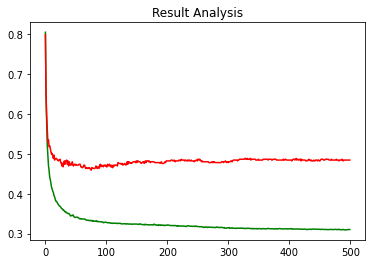

In [12]:
model.train(step_size=1, batch_size=50, max_epoch=500, show_size=50, shuffle=True, select=True)

### Stochastic Gradient Descent

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Epoch 0 of training
Training Loss: 1.80128; Training error: 0.80177; Validation error: 0.82105


 10%|████████                                                                         | 50/500 [00:36<05:35,  1.34it/s]

Epoch 50 of training
Training Loss: 2.14788; Training error: 0.32022; Validation error: 0.47789


 20%|████████████████                                                                | 100/500 [01:13<04:45,  1.40it/s]

Epoch 100 of training
Training Loss: 2.26802; Training error: 0.31036; Validation error: 0.48211


 30%|████████████████████████                                                        | 150/500 [01:50<04:21,  1.34it/s]

Epoch 150 of training
Training Loss: 2.34518; Training error: 0.30593; Validation error: 0.47789


 40%|████████████████████████████████                                                | 200/500 [02:28<03:29,  1.43it/s]

Epoch 200 of training
Training Loss: 2.39771; Training error: 0.30161; Validation error: 0.47579


 50%|████████████████████████████████████████                                        | 250/500 [03:04<03:00,  1.38it/s]

Epoch 250 of training
Training Loss: 2.44586; Training error: 0.29917; Validation error: 0.46737


 60%|████████████████████████████████████████████████                                | 300/500 [03:41<02:23,  1.39it/s]

Epoch 300 of training
Training Loss: 2.47822; Training error: 0.29884; Validation error: 0.46947


 70%|████████████████████████████████████████████████████████                        | 350/500 [04:18<01:51,  1.35it/s]

Epoch 350 of training
Training Loss: 2.50875; Training error: 0.29906; Validation error: 0.46316


 80%|████████████████████████████████████████████████████████████████                | 400/500 [04:55<01:10,  1.41it/s]

Epoch 400 of training
Training Loss: 2.53873; Training error: 0.29795; Validation error: 0.45895


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [05:31<00:35,  1.41it/s]

Epoch 450 of training
Training Loss: 2.55875; Training error: 0.29717; Validation error: 0.46105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:08<00:00,  1.36it/s]

Best model: Epoch 492; Best training error: 0.29596; Best validation error: 0.45684
Result on testing error: 0.498


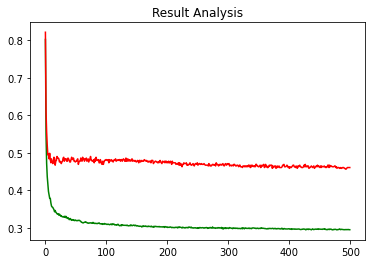

In [13]:
model.train(step_size=5e-2, batch_size=1, max_epoch=500, show_size=50, shuffle=True, select=True)

### Gradient Descent

  0%|▏                                                                                 | 1/500 [00:00<03:36,  2.30it/s]

Epoch 0 of training
Training Loss: 1.77693; Training error: 0.79579; Validation error: 0.82105


 10%|████████▍                                                                        | 52/500 [00:05<00:59,  7.49it/s]

Epoch 50 of training
Training Loss: 1.85834; Training error: 0.37208; Validation error: 0.49053


 20%|████████████████▎                                                               | 102/500 [00:10<00:55,  7.13it/s]

Epoch 100 of training
Training Loss: 1.92060; Training error: 0.34914; Validation error: 0.47368


 30%|████████████████████████▎                                                       | 152/500 [00:15<00:50,  6.83it/s]

Epoch 150 of training
Training Loss: 1.96510; Training error: 0.33873; Validation error: 0.47579


 40%|████████████████████████████████▎                                               | 202/500 [00:19<00:41,  7.19it/s]

Epoch 200 of training
Training Loss: 1.99983; Training error: 0.33263; Validation error: 0.46737


 50%|████████████████████████████████████████▏                                       | 251/500 [00:24<00:32,  7.64it/s]

Epoch 250 of training
Training Loss: 2.02823; Training error: 0.33053; Validation error: 0.46316


 60%|████████████████████████████████████████████████▏                               | 301/500 [00:29<00:27,  7.37it/s]

Epoch 300 of training
Training Loss: 2.05228; Training error: 0.32665; Validation error: 0.46737


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [00:34<00:20,  7.35it/s]

Epoch 350 of training
Training Loss: 2.07313; Training error: 0.32554; Validation error: 0.48211


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [00:39<00:13,  7.34it/s]

Epoch 400 of training
Training Loss: 2.09157; Training error: 0.32355; Validation error: 0.48632


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [00:43<00:06,  7.17it/s]

Epoch 450 of training
Training Loss: 2.10809; Training error: 0.32222; Validation error: 0.49053


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.34it/s]


Best model: Epoch 219; Best training error: 0.33163; Best validation error: 0.46316
Result on testing error: 0.498


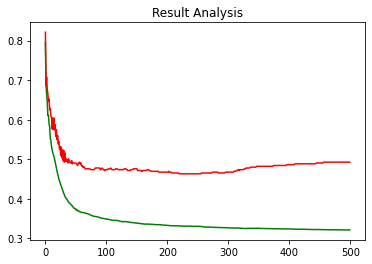

In [14]:
model.train(step_size=100, batch_size=None, max_epoch=500, show_size=50, shuffle=False, select=True)